In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import aplpy

import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/process_tools")
from cut_resize_tools import *
from Astronomy import *

In [2]:
fits_path = "/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/fits/Cygnus_sp16_vs-40_ve040_dv0.25_12CO_Tmb.fits"
integ_hdu = fits.open("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/fits/processed_fits/CygnusX_sp16_120-230_integrate_map.fits")[0]

w_high = WCS(fits_path)
hdu = fits.open(fits_path)[0]
wcs = WCS(integ_hdu.header)

raw_d = hdu.data
header = hdu.header

In [3]:
vsmooth = 5
thresh = 1
sigma = 2
sch_rms = 10
ech_rms = 90
sch_ii = 121
ech_ii = 241
percentile = 99.997
sigma_multiply = None
# width = 60

cut_size_list = [256, 128, 64]
integrate_layer_num = 30
obj_size = 100
maximum_mode = "percentile"

In [4]:
catalogue_path = '/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/cygnus_infer_catalogue.csv' # 提供されたCSVファイル
catalogue_data = pd.read_csv(catalogue_path)

In [5]:
babble_region_galactic = [] # 変換後の銀河座標を格納するリスト
for index, row in catalogue_data.iterrows():
    RA_min = row['ra_min'] * u.deg # 度単位でUnitsオブジェクトを作成
    RA_max = row['ra_max'] * u.deg
    DEC_min = row['dec_min'] * u.deg
    DEC_max = row['dec_max'] * u.deg

    # 各角の赤経・赤緯座標をSkyCoordオブジェクトとして定義
    # そして銀河座標系に変換
    # RA_min, DEC_min の点
    coord_min_min = SkyCoord(ra=RA_min, dec=DEC_min, frame='icrs').galactic
    # RA_max, DEC_min の点
    coord_max_min = SkyCoord(ra=RA_max, dec=DEC_min, frame='icrs').galactic
    # RA_min, DEC_max の点
    coord_min_max = SkyCoord(ra=RA_min, dec=DEC_max, frame='icrs').galactic
    # RA_max, DEC_max の点
    coord_max_max = SkyCoord(ra=RA_max, dec=DEC_max, frame='icrs').galactic

    # 変換された銀河座標 (l, b) のリストを作成
    babble_region_galactic.append([
        [coord_min_min.l.deg, coord_min_min.b.deg], # 0: L_min, B_min
        [coord_max_min.l.deg, coord_max_min.b.deg], # 1: L_max, B_min
        [coord_min_max.l.deg, coord_min_max.b.deg], # 2: L_min, B_max
        [coord_max_max.l.deg, coord_max_max.b.deg]  # 3: L_max, B_max
    ])
print(f"babble_region_galactic len: {len(babble_region_galactic)}")


# --- babble_region_pix への変換 (修正) ---
# ループ元を babble_region_galactic に変更
babble_region_pix = []
for i in range(len(babble_region_galactic)):
    babble_region = babble_region_galactic[i] # 銀河座標のバブル領域
    region_list = []
    for j in range(len(babble_region)):
        world_coords_list = [list(babble_region[j])] # [L, B] のリスト
        
        # WCS変換。世界座標 (L, B) をピクセル座標に変換
        # origin=0 でPythonの0-based indexに対応
        region_pix_result = wcs.wcs_world2pix(world_coords_list, 0)

        # 変換結果の形状と要素数をチェックする
        if len(region_pix_result) > 0 and len(region_pix_result[0]) == 2:
            region_list.append(region_pix_result[0]) # 期待通り [x, y] を追加
        else:
            print(f"警告: bubble_num={i}, point_idx={j} のWCS変換結果が不正です: {region_pix_result}. NaNで埋めます。")
            region_list.append([np.nan, np.nan]) # NaNで埋めて、後で除外されるようにする

    babble_region_pix.append(region_list)
print(f"babble_region_pix len: {len(babble_region_pix)}")

babble_region_galactic len: 78
babble_region_pix len: 78


In [6]:
cutting_ratio = 2
cutting_data_dic = {}
data_to_cut = raw_d.copy() # raw_d からのコピー

for bubble_num in range(len(babble_region_pix)):
    all_x_coords = [p[0] for p in babble_region_pix[bubble_num]]
    all_y_coords = [p[1] for p in babble_region_pix[bubble_num]]

    # ピクセル座標の最小値と最大値を取得
    # np.min と np.max を使うことで、座標の順序に関わらず正しい矩形領域の境界を取得
    # これにより、x_max_pix < x_min_pix のような逆転を防ぎ、スライス範囲が巨大になるのを防ぐ
    x_min_pix = int(np.floor(np.min(all_x_coords)))
    x_max_pix = int(np.ceil(np.max(all_x_coords)))
    y_min_pix = int(np.floor(np.min(all_y_coords)))
    y_max_pix = int(np.ceil(np.max(all_y_coords)))

    x_center = (x_min_pix + x_max_pix) // 2 
    y_center = (y_min_pix + y_max_pix) // 2
    
    x_range = (x_max_pix - x_min_pix) // 2 * cutting_ratio
    y_range = (y_max_pix - y_min_pix) // 2 * cutting_ratio

    x_min_pix = int(x_center - x_range)
    x_max_pix = int(x_center + x_range)
    y_min_pix = int(y_center - y_range)
    y_max_pix = int(y_center + y_range)

    # 切り出し実行
    # ここでは、np.clip を使用せず、NumPyのスライスが範囲外を0で自動パディングする動作に任せる
    # ただし、x_min_pix/y_min_pix が負になったり、x_max_pix/y_max_pix が大きくなりすぎたりすると、
    # 巨大な配列が生成される可能性がある点に注意（メモリ消費、処理時間）
    cutting_data = data_to_cut[:, y_min_pix:y_max_pix, x_min_pix:x_max_pix]
    pix_cood = (x_min_pix, x_max_pix, y_min_pix, y_max_pix)
    cutting_data_dic[pix_cood] = cutting_data

    # デバッグ用に切り出したデータの形状と範囲を表示してみる
    # print(f"Bubble {bubble_num}: X range [{x_min_pix}, {x_max_pix}], Y range [{y_min_pix}, {y_max_pix}], Shape: {cutting_data.shape}")

In [7]:
deleted_indices = []
filtered_list = [
    data for idx, data in enumerate(cutting_data_dic.items()) 
    if not np.all((data[1] == 0) | np.isnan(data[1]))
    or deleted_indices.append(idx)  # 削除されたインデックスを記録
]

# 削除されたインデックスを表示
print("削除されたデータのインデックス:", deleted_indices)
print("削除された数: ", len(deleted_indices))
print("残ったデータ数: ",len(filtered_list))

削除されたデータのインデックス: [4, 6, 8, 10, 11, 12, 19, 22, 24, 26, 27, 31, 33, 34, 36, 37, 38, 39, 42, 44, 45, 46, 50, 51, 53, 54, 55, 57, 59, 60, 61, 63, 64, 65, 68, 71, 73]
削除された数:  37
残ったデータ数:  41


In [8]:
remove_list = [0, 5, 8, 9, 10, 12, 17, 19, 21, 34]
filtered_list = [data for i, data in enumerate(filtered_list) if i not in remove_list]

In [9]:
all_map = raw_d.copy()

In [10]:
for pdu in filtered_list:
    pdu = pdu[0]
    x_min, x_max, y_min, y_max = pdu[0], pdu[1], pdu[2], pdu[3]

    # 1. 対象領域をスライスで取得
    region = all_map[:, y_min:y_max, x_min:x_max]
    
    # 2. 領域内でNaNではない要素のマスクを作成
    # np.isnan(region) は NaN の位置が True になる
    # ~ で論理反転させ、NaNで「ない」位置を True にする
    not_nan_mask = ~np.isnan(region)
    
    # 3. マスクがTrueの位置（NaNでない要素）だけを0にする
    region[not_nan_mask] = np.nan

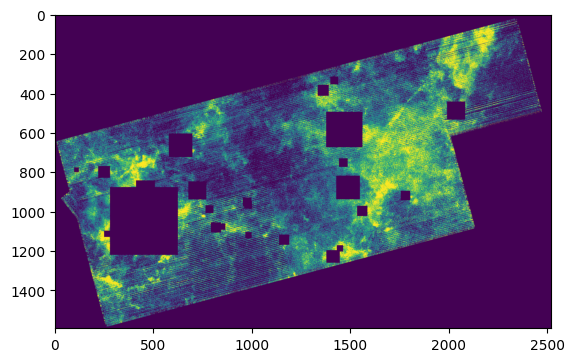

In [11]:
plt.imshow(np.nansum(all_map, axis=0), vmin=0, vmax=500)

In [12]:
val_x_min = 1350
val_x_max = 2150
val_y_min = 800
val_y_max = 1300

test_y_min = 1020
test_y_max = 1500
test_x_min = 700
test_x_max = 1350

In [13]:
trainig_map = all_map.copy()

region = trainig_map[:, val_y_min:val_y_max, val_x_min:val_x_max]
not_nan_mask = ~np.isnan(region)
region[not_nan_mask] = np.nan

region = trainig_map[:, test_y_min:test_y_max, test_x_min:test_x_max]
not_nan_mask = ~np.isnan(region)
region[not_nan_mask] = np.nan

In [14]:
validation_map = all_map.copy()
validation_map = validation_map[:, val_y_min:val_y_max, val_x_min:val_x_max]

test_map = all_map.copy()
test_map = test_map[:, test_y_min:test_y_max, test_x_min:test_x_max]

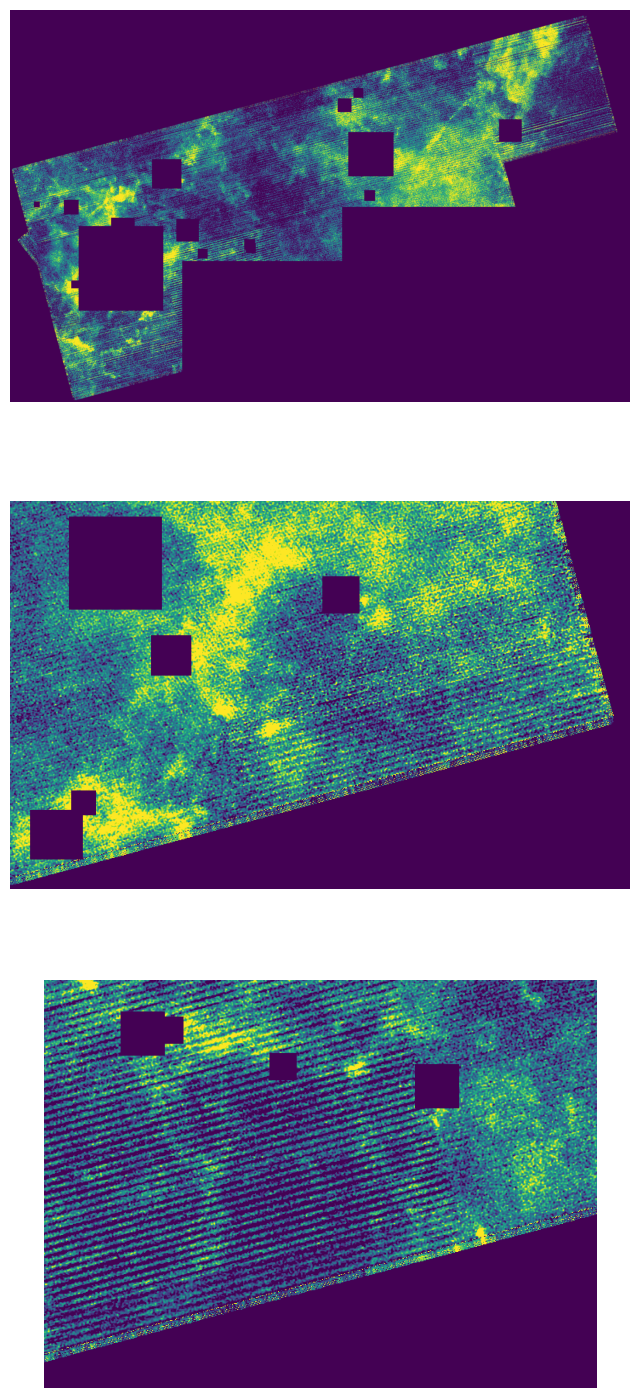

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(8, 18))
axes[0].imshow(np.nansum(trainig_map, axis=0), vmin=0, vmax=500)
axes[0].axis("off")

axes[1].imshow(np.nansum(validation_map, axis=0), vmin=0, vmax=500)
axes[1].axis("off")

axes[2].imshow(np.nansum(test_map, axis=0), vmin=0, vmax=500)
axes[2].axis("off")

plt.show()

In [16]:
processed_training_list = []
for pix in cut_size_list:
    print(f"Processing data clipped to {pix} pixels...")

    # Step1: スライス
    cut_data = slide(trainig_map, pix+4, 4)
    print(f"Number of data clipped to {pix} pixels: {len(cut_data)}")

    cut_data = remove_nan(cut_data)
    print(f"Number of data after deletion: {len(cut_data)}")

    # Step2: 並列前処理
    processed_list = parallel_processing(
                                        function=process_data_segment, 
                                        target=cut_data,
                                        vsmooth=vsmooth,
                                        sch_rms=sch_rms, 
                                        ech_rms=ech_rms,
                                        sch_ii=sch_ii,
                                        ech_ii=ech_ii,
                                        sigma=sigma, 
                                        thresh=thresh, 
                                        integrate_layer_num=integrate_layer_num
                                        )
    processed_training_list += processed_list

Processing data clipped to 256 pixels...
Number of data clipped to 256 pixels: 735
Number of data after deletion: 41
Processing data clipped to 128 pixels...
Number of data clipped to 128 pixels: 3285
Number of data after deletion: 507
Processing data clipped to 64 pixels...
Number of data clipped to 64 pixels: 13050
Number of data after deletion: 3277


In [17]:
processed_validation_list = []
for pix in cut_size_list:
    print(f"Processing data clipped to {pix} pixels...")

    # Step1: スライス
    cut_data = slide(validation_map, pix+4, 4)
    print(f"Number of data clipped to {pix} pixels: {len(cut_data)}")

    cut_data = remove_nan(cut_data)
    print(f"Number of data after deletion: {len(cut_data)}")

    # Step2: 並列前処理
    processed_list = parallel_processing(
                                        function=process_data_segment, 
                                        target=cut_data,
                                        vsmooth=vsmooth,
                                        sch_rms=sch_rms, 
                                        ech_rms=ech_rms,
                                        sch_ii=sch_ii,
                                        ech_ii=ech_ii,
                                        sigma=sigma, 
                                        thresh=thresh, 
                                        integrate_layer_num=integrate_layer_num
                                        )
    processed_validation_list += processed_list

Processing data clipped to 256 pixels...
Number of data clipped to 256 pixels: 36
Number of data after deletion: 0
Processing data clipped to 128 pixels...
Number of data clipped to 128 pixels: 252
Number of data after deletion: 61
Processing data clipped to 64 pixels...
Number of data clipped to 64 pixels: 1144
Number of data after deletion: 530


In [18]:
processed_test_list = []
for pix in cut_size_list:
    print(f"Processing data clipped to {pix} pixels...")

    # Step1: スライス
    cut_data = slide(test_map, pix+4, 1)
    print(f"Number of data clipped to {pix} pixels: {len(cut_data)}")

    cut_data = remove_nan(cut_data)
    print(f"Number of data after deletion: {len(cut_data)}")

    # Step2: 並列前処理
    processed_list = parallel_processing(
                                        function=process_data_segment, 
                                        target=cut_data,
                                        vsmooth=vsmooth,
                                        sch_rms=sch_rms, 
                                        ech_rms=ech_rms,
                                        sch_ii=sch_ii,
                                        ech_ii=ech_ii,
                                        sigma=sigma, 
                                        thresh=thresh, 
                                        integrate_layer_num=integrate_layer_num
                                        )
    processed_test_list += processed_list

Processing data clipped to 256 pixels...
Number of data clipped to 256 pixels: 2
Number of data after deletion: 0
Processing data clipped to 128 pixels...
Number of data clipped to 128 pixels: 12
Number of data after deletion: 3
Processing data clipped to 64 pixels...
Number of data clipped to 64 pixels: 63
Number of data after deletion: 33


In [19]:
max_thresh = maximum_value_determination(
                                                     mode=maximum_mode, 
                                                     data=raw_d, 
                                                     vsmooth=vsmooth, 
                                                     sch_rms=sch_rms, 
                                                     ech_rms=ech_rms, 
                                                     sch_ii=sch_ii, 
                                                     ech_ii=ech_ii, 
                                                     sigma=sigma, 
                                                     thresh=thresh, 
                                                     integrate_layer_num=integrate_layer_num, 
                                                     percentile=percentile
                                                    )

======== maximum determination ========
-------- making v_convolution data --------
-------- masking data --------


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


-------- integrating and xy_convolution --------
percentile value is 132.73


In [22]:
conv_resize_training_list = []
for _data in tqdm(processed_training_list):
    # _data = select_conv(_data, obj_size, obj_sig)
    _data = resize(_data, (obj_size+4, obj_size+4))
    _data = gaussian_filter(_data)
    if maximum_mode in ["percentile", "sigma"]:
        _data = np.clip(_data, a_min=None, a_max=max_thresh)
    conv_resize_training_list.append(_data)

conv_resize_training_list = normalization_thresh(conv_resize_training_list, max_thresh)


conv_resize_validation_list = []
for _data in tqdm(processed_validation_list):
    # _data = select_conv(_data, obj_size, obj_sig)
    _data = resize(_data, (obj_size+4, obj_size+4))
    _data = gaussian_filter(_data)
    if maximum_mode in ["percentile", "sigma"]:
        _data = np.clip(_data, a_min=None, a_max=max_thresh)
    conv_resize_validation_list.append(_data)

conv_resize_validation_list = normalization_thresh(conv_resize_validation_list, max_thresh)


conv_resize_test_list = []
for _data in tqdm(processed_test_list):
    # _data = select_conv(_data, obj_size, obj_sig)
    _data = resize(_data, (obj_size+4, obj_size+4))
    _data = gaussian_filter(_data)
    if maximum_mode in ["percentile", "sigma"]:
        _data = np.clip(_data, a_min=None, a_max=max_thresh)
    conv_resize_test_list.append(_data)

conv_resize_test_list = normalization_thresh(conv_resize_test_list, max_thresh)

  0%|          | 0/3825 [00:00<?, ?it/s]

  0%|          | 0/591 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

In [23]:
# np.save("./processed_data/split_area/training_data/training_data", conv_resize_training_list)
np.save("./processed_data/split_area/validation_data/validation_cheating_data", conv_resize_validation_list)
# np.save("./processed_data/split_area/test_data/test_data", conv_resize_test_list)

In [24]:
len(conv_resize_validation_list)

591